In [1]:
! conda info --envs

# conda environments:
#
base                     C:\Users\bhave\anaconda3
lipnet_v1             *  C:\Users\bhave\anaconda3\envs\lipnet_v1
pdf-reader               C:\Users\bhave\anaconda3\envs\pdf-reader
py39-tf210-env           C:\Users\bhave\anaconda3\envs\py39-tf210-env
pytorch_env              C:\Users\bhave\anaconda3\envs\pytorch_env
pytorch_env_assign       C:\Users\bhave\anaconda3\envs\pytorch_env_assign
tensorflow-assign-env     C:\Users\bhave\anaconda3\envs\tensorflow-assign-env
tf-gpu                   C:\Users\bhave\anaconda3\envs\tf-gpu



### Downloading and Importing the Dependences Required

In [2]:
! pip install tensorflow==2.10.0 opencv-python matplotlib imageio gdown

In [3]:
! pip list

Package                      Version
---------------------------- ------------------
absl-py                      2.1.0
antlr4-python3-runtime       4.9.3
asttokens                    2.4.1
astunparse                   1.6.3
beautifulsoup4               4.12.3
cachetools                   5.3.3
certifi                      2024.2.2
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.2.0
cycler                       0.12.1
dataclasses                  0.6
debugpy                      1.8.1
decorator                    5.1.1
exceptiongroup               1.2.0
executing                    2.0.1
filelock                     3.13.1
fire                         0.5.0
flatbuffers                  24.3.7
fonttools                    4.49.0
fvcore                       0.1.5.post20221221
gast                         0.4.0
gdown                        5.1.0
google-auth                  2.28.2
google-auth-oauthlib

In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
physical_device = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_device[0], True)
except:
    pass

### 1. Building Data Loading Functions

In [7]:
import gdown

In [8]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=18b780b7-4163-4c9f-a111-cc6973024d3e
To: c:\Bhavesh\Humber SEM 2\Image Processing and Computer Vision\Final Project\LipNet Project\data.zip
100%|██████████| 423M/423M [00:08<00:00, 49.5MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [9]:
# Get the video convert it into frames loop through each frame and capture the lip section using static slicer.

# def load_video(path:str) -> List[float]:

#     cap = cv2.VideoCapture(path)
#     frames = []
#     for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
#         ret, frame = cap.read()
#         frame = tf.image.rgb_to_grayscale(frame)
#         frames.append(frame[190:236,80:220,:])
#     cap.release()

#     # Standardize the frames captured for data normalization
#     mean = tf.math.reduce_mean(frames)
#     std = tf.math.reduce_std(tf.cast(frames, tf.float32))
#     return tf.cast((frames - mean), tf.float32) / std

In [10]:
# Get the video convert it into frames loop through each frame and capture the lip section using static slicer.
# Take care of out-of-bound error for video dimension.

def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        
        # Check if the lip section is within the bounds of the frame
        if frame.shape[0] >= 236 and frame.shape[1] >= 220:
            lip_section = frame[190:236, 80:220, :]
            frames.append(lip_section)
        
    cap.release()

    # Standardize the frames captured for data normalization
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std



In [11]:
# This Vocab variable will contain every single character that we expect to have in our dataset
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [12]:
# this is deom Automatic Speech Recognition using CTC - Keras doc.
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =40)


In [13]:
# Example of char to num into a vector form
char_to_num(['b','h','a','v','e','s','h'])
#char_to_num.get_vocabulary()


<tf.Tensor: shape=(7,), dtype=int64, numpy=array([ 2,  8,  1, 22,  5, 19,  8], dtype=int64)>

In [14]:
# convert back from vector to char form
num_to_char([ 2,  8,  1, 22,  5, 19,  8])

<tf.Tensor: shape=(7,), dtype=string, numpy=array([b'b', b'h', b'a', b'v', b'e', b's', b'h'], dtype=object)>

In [15]:
# Load up our alignments and split each line and remove the sil 'silence' from the file as the speaker is just silent.
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    # Reading each line from the file.
    for line in lines:
        line = line.split()
        # Ignore the line if it is 'sil' ie. silence
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    # Convert the characters to numbers.
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [16]:
# This funtion will load our data and the alignment simultaneously.
def load_data(path: str): 
    path = bytes.decode(path.numpy())

    # File name splitting
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    # Check if files exist
    if not (os.path.exists(video_path) and os.path.exists(alignment_path)):
        raise FileNotFoundError(f"Video or alignment file not found for {file_name}")

    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    # Returning the preprocessed video and alignments
    return frames, alignments

In [17]:
# Testing our function with taking a single video.
test_path = '.\\data\\s1\\bbaf3s.mpg'

In [18]:

tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbaf3s'

In [19]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [20]:
frames[1].shape

TensorShape([46, 140, 1])

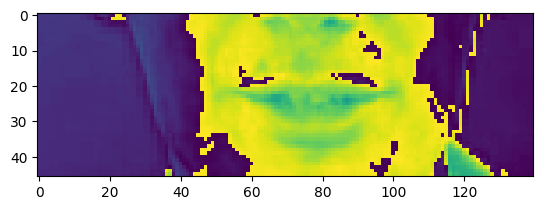

In [21]:
plt.imshow(frames[30])

In [22]:
# The word representation of what is been said in vector form.
alignments

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20,  8, 18,
        5,  5, 39, 19, 15, 15, 14], dtype=int64)>

In [23]:
# The word representation of whats been said.
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f three soon'>

In [24]:
# Working with the specific file path formats
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

### 2. Creating a Data Pipeline

In [25]:
# Grab the data from the s1 folder with an extension of .mpg format.
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# Shuffle the data to get random samples
data = data.shuffle(500, reshuffle_each_iteration=False)

data = data.map(mappable_function)
# Created a padded batch as each alignments with 40 and each frames with 75 by make it of a standard length.
data = data.padded_batch(1, padded_shapes=([75,None,None,None],[40]))
# Preload the data when the ML model is learning for passing the next set.
data = data.prefetch(tf.data.AUTOTUNE)

# Added for split 
train = data.take(450)
test = data.skip(450)

In [26]:
len(test)

550

In [27]:
frames, alignments = data.as_numpy_iterator().next()

In [28]:
len(frames)

1

In [29]:
sample = data.as_numpy_iterator()

In [30]:
val = sample.next(); val[0]

array([[[[[ 1.4571382 ],
          [ 1.4571382 ],
          [ 1.5380903 ],
          ...,
          [ 0.28333244],
          [ 0.16190425],
          [ 0.16190425]],

         [[ 1.4571382 ],
          [ 1.4571382 ],
          [ 1.5380903 ],
          ...,
          [ 0.28333244],
          [ 0.16190425],
          [ 0.16190425]],

         [[ 1.4976143 ],
          [ 1.4976143 ],
          [ 1.4166621 ],
          ...,
          [ 0.28333244],
          [ 0.2023803 ],
          [ 0.2023803 ]],

         ...,

         [[ 0.9309494 ],
          [ 0.9309494 ],
          [ 0.9309494 ],
          ...,
          [10.321396  ],
          [10.321396  ],
          [10.321396  ]],

         [[ 0.9309494 ],
          [ 0.9309494 ],
          [ 0.9309494 ],
          ...,
          [10.28092   ],
          [10.28092   ],
          [10.28092   ]],

         [[ 0.9309494 ],
          [ 0.9309494 ],
          [ 0.9309494 ],
          ...,
          [10.28092   ],
          [10.28092   ],
          

In [31]:
float_array = val[0][0]

# Create a list of frames
frames = [frame.squeeze() for frame in float_array]

# Rescale the values to [0, 255] for temporary representation during saving
rescaled_frames = [(frame - np.min(frame)) / (np.max(frame) - np.min(frame)) * 255 for frame in frames]

# Convert to 8-bit unsigned integer for saving as a GIF
rescaled_frames_uint8 = [frame.astype(np.uint8) for frame in rescaled_frames]

# Save the GIF
imageio.mimsave('./animation.gif', rescaled_frames_uint8, fps=10)

In [32]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [34]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [36]:
#yhat = model.predict(val[0])

In [37]:
#tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

In [38]:
#tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

In [39]:
model.input_shape

(None, 75, 46, 140, 1)

In [40]:
model.output_shape

(None, 75, 41)

### 4.Setup Training Oprations and Train

In [41]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [42]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [45]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [46]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [47]:
schedule_callback = LearningRateScheduler(scheduler)

In [49]:
model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/50


450/450 [==============================] - 463s 974ms/step - loss: 86.6377 - val_loss: 70.5277 - lr: 1.0000e-04
Epoch 2/50
450/450 [==============================] - 414s 920ms/step - loss: 73.1736 - val_loss: 67.4277 - lr: 1.0000e-04
Epoch 3/50
450/450 [==============================] - 408s 908ms/step - loss: 68.8975 - val_loss: 65.1575 - lr: 1.0000e-04
Epoch 4/50
450/450 [==============================] - 407s 905ms/step - loss: 66.8549 - val_loss: 63.5541 - lr: 1.0000e-04
Epoch 5/50
450/450 [==============================] - 413s 918ms/step - loss: 64.9475 - val_loss: 61.2561 - lr: 1.0000e-04
Epoch 6/50
450/450 [==============================] - 409s 909ms/step - loss: 63.3297 - val_loss: 59.8473 - lr: 1.0000e-04
Epoch 7/50
450/450 [==============================] - 413s 919ms/step - loss: 62.0703 - val_loss: 58.9283 - lr: 1.0000e-04
Epoch 8/50
450/450 [==============================] - 417s 928ms/step - loss: 60.8300 - val_loss: 57.1867 - lr: 1.0000e-04
Epoch 9/50
450/450 [=======

### Make a Prediction 
Trained on 100 epochs that I trained the model on and created those checkpoints - Load them and do prediction

In [50]:
# model.load_weights('models/checkpoint')

In [51]:
# Model Testing on the 96 epochs checkpoint model.

model.load_weights('models_checkpoint_96/checkpoint')

In [52]:
test_data = test.as_numpy_iterator()

In [53]:
sample = test_data.next()

In [54]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [55]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white in p six now'>]

In [56]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [57]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white in p six now'>]

### Test on Video

In [58]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [59]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [60]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 123ms/step


In [61]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [62]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]